<a href="https://colab.research.google.com/github/MorganPeju/inf8225_project/blob/main/INF8225_Custom_YOLOv5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Presentation
## Project INF8225 - YOLOv5 for fire smoke detection

**Team**
- Renaud Lespérance
- Gabriel Poupart
- Chu Ka Hei
- Morgan Péju

**Data**

We're using annotated datasets from AI For Mankind, a non-profit organization whose mission is to mobilize the technology community to work on global problems using AI and data. AI For Mankind annotated public photos from HPWREN with bounding boxes for object detection.
-	Dataset 1 : 744 annotated images
-	Dataset 2 : 2192 annotated images
- Source : https://github.com/aiformankind/wildfire-smoke-dataset

- Dataset Clouds : 1247 images
- Source : https://drive.google.com/file/d/1aYoCF64DkC9jC7T6H5UTaxwCXrosy4io/view

**Goal**

The aim of this project is to set up a YOLO model to detect fire smoke. 


# Install YOLO & load libraries

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # Clone of YOLOv5
%cd yolov5
%pip install -qr requirements.txt  # Requirements installation
%pip install -q wandb

import wandb
import torch
from yolov5 import utils
display = utils.notebook_init()  # Checks

YOLOv5 🚀 v6.1-167-g488fb0a torch 1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.4/166.8 GB disk)


In [ ]:
# Load libraries
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import yaml
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

import cv2
import xml.etree.ElementTree as etree
from google.colab.patches import cv2_imshow
from google.colab import files

!pip install --upgrade --no-cache-dir gdown #NEED to uptade gdown to download dataset

# Preprocessing


## Load Datasets

In [ ]:
### Dataset import and extraction
! gdown 1sEB77bfp2yMkgsSW9703vwDHol_cK6D5 -O smoke_dataset_V1.tar.gz
! gdown 1dpTDihAN47rSBRGn_XpEYCCcchXrxnZ0 -O smoke_dataset_V2.tar.gz
! gdown 1aYoCF64DkC9jC7T6H5UTaxwCXrosy4io -O challenge1.tar.gz
! mkdir -p /content/yolov5/datasets/smoke_dataset_V1
! mkdir -p /content/yolov5/datasets/smoke_dataset_V2
! mkdir -p /content/yolov5/datasets/clouds_dataset
! tar xzf smoke_dataset_V1.tar.gz -C '/content/yolov5/datasets/smoke_dataset_V1'
! tar xzf smoke_dataset_V2.tar.gz -C '/content/yolov5/datasets/smoke_dataset_V2'
! tar xzf challenge1.tar.gz -C '/content/yolov5/datasets/clouds_dataset'

Downloading...
From: https://drive.google.com/uc?id=1sEB77bfp2yMkgsSW9703vwDHol_cK6D5
To: /content/yolov5/smoke_dataset_V1.tar.gz
100% 28.6M/28.6M [00:00<00:00, 98.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dpTDihAN47rSBRGn_XpEYCCcchXrxnZ0
To: /content/yolov5/smoke_dataset_V2.tar.gz
100% 501M/501M [00:02<00:00, 178MB/s]
Downloading...
From: https://drive.google.com/uc?id=1aYoCF64DkC9jC7T6H5UTaxwCXrosy4io
To: /content/yolov5/challenge1.tar.gz
100% 1.74G/1.74G [00:13<00:00, 133MB/s]


In [ ]:
smoke_dataset_V1_path = "/content/yolov5/datasets/smoke_dataset_V1"
smoke_dataset_V1_images_folder = "/annotated_bounding_box_hpwren/images"
smoke_dataset_V1_annotations_folder = "/annotated_bounding_box_hpwren/xmls"
smoke_dataset_V2_path = "/content/yolov5/datasets/smoke_dataset_V2"
smoke_dataset_V2_images_folder = "/day_time_wildfire_v2/images"
smoke_dataset_V2_annotations_folder = "/day_time_wildfire_v2/annotations/xmls"
clouds_dataset_path = "/content/yolov5/datasets/clouds_dataset"
clouds_dataset_images_folder = "/challenge1/no_smoke"
clouds_dataset_annotations_folder = "/annotations"

## Convert Annotation : XML to TXT

YOLOv5 supports bounding box annotation text file. Thus we need to convert our datasets' .XML file to .TXT.

In [ ]:
# Function to get the data from XML Annotation
def extract_info_from_xml(
    datasets_path,
    images_folder,
    xml_folder,
    file_name
    ):
    """
    Get annotations' information from a xml file

    Args
    ----
        datasets_path : datasets' path location
        images_folder : path to images' folder
        xml_folder : path to annotations' folder
        file_name: file name

    Output
    ------
        info_dict : dictionnary of the annotation information
    """
    xml_file_path = f"{datasets_path}{xml_folder}/{file_name}.xml"
    root = etree.parse(xml_file_path).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        textInInt = int(float(subsubelem.text))  
                        bbox[subsubelem.tag] = textInInt           
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [ ]:
## Test
file_name = "ck0txrkyx611l0a46u3b4n8bb"
test = extract_info_from_xml(smoke_dataset_V1_path,smoke_dataset_V1_images_folder,smoke_dataset_V1_annotations_folder,file_name)

print(test)


{'bboxes': [{'class': 'smoke', 'xmin': 217, 'ymin': 204, 'xmax': 254, 'ymax': 240}], 'filename': 'ck0txrkyx611l0a46u3b4n8bb.jpeg', 'image_size': (640, 480, 3)}


In [ ]:
# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(
    xml_folder,
    info_dict,
    class_name_to_id_mapping
    ):
    """
    Create annotations' information file (.txt) required for yolo format

    Args
    ----
        xml_folder : path to annotations' folder
        info_dict : dictionnary of the annotation information
        class_name_to_id_mapping : dictionnary of classes to detect

    Output
    ------
        Create and save annotations' information file (.txt)
    """
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join(xml_folder, info_dict["filename"].replace("jpeg", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [ ]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"smoke": 0}
# Get the annotations
xml_folder_path = f"{smoke_dataset_V1_path}{smoke_dataset_V1_annotations_folder}"

annotations = [x[:-4] for x in os.listdir(xml_folder_path) if x[-3:] == "xml"]
annotations.sort()
prefixes = ('._')



for word in annotations[:]:
    if word.startswith(prefixes):
        annotations.remove(word)


# Convert and save the annotations
for filename in tqdm(annotations):
    info_dict = extract_info_from_xml(smoke_dataset_V1_path,smoke_dataset_V1_images_folder,smoke_dataset_V1_annotations_folder,filename)
    convert_to_yolov5(xml_folder_path,info_dict,class_name_to_id_mapping)
annotations = [os.path.join(xml_folder_path, x) for x in os.listdir(xml_folder_path) if x[-3:] == "txt"]


100%|██████████| 744/744 [00:00<00:00, 7745.83it/s]


### Display Bounding Box

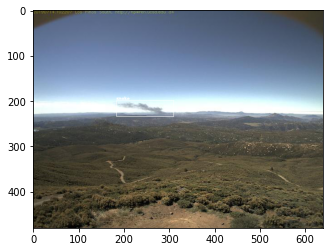

In [ ]:
def plot_bounding_box(
    image, 
    annotation_list, 
    class_id_to_name_mapping
    ):
    """
    Display an image with its bounding boxes from its .JPEG file and annotation (.TXT)

    Args
    ----
        image : image file
        annotation_list : annotations information
        class_name_to_id_mapping : dictionnary of classes to detect

    Output
    ------
        Display an image with its bounding boxes
    """
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
random.seed(0)
annotation_file = random.choice(annotations)

with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("xmls", "images").replace("txt", "jpeg")

assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))
plot_bounding_box(image, annotation_list, class_id_to_name_mapping)


### Convert Annotation for V2

In [ ]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"smoke": 0}
# Get the annotations
xml_folder_path = f"{smoke_dataset_V2_path}{smoke_dataset_V2_annotations_folder}"

annotations_v2 = [x[:-4] for x in os.listdir(xml_folder_path) if x[-3:] == "xml"]
annotations_v2.sort()
prefixes = ('._')



for word in annotations_v2[:]:
    if word.startswith(prefixes):
        annotations_v2.remove(word)


# Convert and save the annotations
for filename in tqdm(annotations_v2):
    info_dict = extract_info_from_xml(smoke_dataset_V2_path,smoke_dataset_V2_images_folder,smoke_dataset_V2_annotations_folder,filename)
    convert_to_yolov5(xml_folder_path,info_dict,class_name_to_id_mapping)
annotations_v2 = [os.path.join(xml_folder_path, x) for x in os.listdir(xml_folder_path) if x[-3:] == "txt"]


100%|██████████| 2191/2191 [00:00<00:00, 5472.15it/s]


### Create Blank Annotation for V3

In [ ]:
images_folder_path = f"{clouds_dataset_path}{clouds_dataset_images_folder}"
annotations_folder_path = f"{clouds_dataset_path}{clouds_dataset_annotations_folder}"

images = [x[:-4] for x in os.listdir(images_folder_path) if x[-3:] == "jpg"]

! mkdir -p {annotations_folder_path}

for filename in tqdm(images):
    # Name of the file which we have to save 
    save_file_name = os.path.join(annotations_folder_path, filename) + ".txt"
    
    # Save the annotation to disk
    with open(save_file_name, "w") as _:
      pass
    #file.close()
    #print("\n", file= open(save_file_name, "a"))

100%|██████████| 1246/1246 [00:00<00:00, 26812.49it/s]


## Train/Test/Val split and preparation

In [ ]:
# Read images and annotations
xml_folder_path = f"{smoke_dataset_V1_path}{smoke_dataset_V1_annotations_folder}"
images_folder_path = f"{smoke_dataset_V1_path}{smoke_dataset_V1_images_folder}"

images = [os.path.join(images_folder_path, x) for x in os.listdir(images_folder_path)]
annotations = [os.path.join(xml_folder_path, x) for x in os.listdir(xml_folder_path) if x[-3:] == "txt"]

images.sort()
annotations.sort()

prefixes = (images_folder_path+'/._',xml_folder_path+'/._')
for word in annotations[:]:
    if word.startswith(prefixes):
        annotations.remove(word)
for word in images[:]:
    if word.startswith(prefixes):
        images.remove(word)

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)


In [ ]:
!mkdir -p images/train 
!mkdir -p images/val 
!mkdir -p images/test 
!mkdir -p labels/train 
!mkdir -p labels/val 
!mkdir -p labels/test

In [ ]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print("Files already exist")
            #print(f)
            #assert False

# Move the splits into their folders

move_files_to_folder(train_images, '/content/yolov5/images/train')
move_files_to_folder(val_images, '/content/yolov5/images/val/')
move_files_to_folder(test_images, '/content/yolov5/images/test/')
move_files_to_folder(train_annotations, '/content/yolov5/labels/train/')
move_files_to_folder(val_annotations, '/content/yolov5/labels/val/')
move_files_to_folder(test_annotations, '/content/yolov5/labels/test/')


Code for 2nd dataset

In [ ]:
# Read images and annotations
xml_folder_path = f"{smoke_dataset_V2_path}{smoke_dataset_V2_annotations_folder}"
images_folder_path = f"{smoke_dataset_V2_path}{smoke_dataset_V2_images_folder}"

images_v2 = []
images_v2 = [os.path.join(images_folder_path, x) for x in os.listdir(images_folder_path) if x[-4:] == "jpeg"]
annotations_v2 = []
annotations_v2 = [os.path.join(xml_folder_path, x) for x in os.listdir(xml_folder_path) if x[-3:] == "txt"]

images_v2.sort()
annotations_v2.sort()

prefixes = (images_folder_path+'/._',xml_folder_path+'/._')
for word in annotations_v2[:]:
    if word.startswith(prefixes):
        annotations_v2.remove(word)
for word in images_v2[:]:
    if word.startswith(prefixes):
        images_v2.remove(word)


# Split the dataset into train-valid-test splits 
train_images_v2, val_images_v2, train_annotations_v2, val_annotations_v2 = train_test_split(images_v2, annotations_v2, test_size = 0.2, random_state = 1)
val_images_v2, test_images_v2, val_annotations_v2, test_annotations_v2 = train_test_split(val_images_v2, val_annotations_v2, test_size = 0.5, random_state = 1)

#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print("Files already exist")
            #print(f)
            #assert False

# Move the splits into their folders

move_files_to_folder(train_images_v2, '/content/yolov5/images/train')
move_files_to_folder(val_images_v2, '/content/yolov5/images/val/')
move_files_to_folder(test_images_v2, '/content/yolov5/images/test/')
move_files_to_folder(train_annotations_v2, '/content/yolov5/labels/train/')
move_files_to_folder(val_annotations_v2, '/content/yolov5/labels/val/')
move_files_to_folder(test_annotations_v2, '/content/yolov5/labels/test/')



Code for Clouds dataset

In [ ]:
# Read images and annotations
xml_folder_path = f"{clouds_dataset_path}{clouds_dataset_annotations_folder}"
images_folder_path = f"{clouds_dataset_path}{clouds_dataset_images_folder}"

images_clouds = []
images_clouds = [os.path.join(images_folder_path, x) for x in os.listdir(images_folder_path) if x[-3:] == "jpg"]
annotations_clouds = []
annotations_clouds = [os.path.join(xml_folder_path, x) for x in os.listdir(xml_folder_path) if x[-3:] == "txt"]

images_clouds.sort()
annotations_clouds.sort()

prefixes = (images_folder_path+'/._',xml_folder_path+'/._')
for word in annotations_clouds[:]:
    if word.startswith(prefixes):
        annotations_clouds.remove(word)
for word in images_clouds[:]:
    if word.startswith(prefixes):
        images_clouds.remove(word)


# Split the dataset into train-valid-test splits 
train_images_clouds, val_images_clouds, train_annotations_clouds, val_annotations_clouds = train_test_split(images_clouds, annotations_clouds, test_size = 0.2, random_state = 1)
val_images_clouds, test_images_clouds, val_annotations_clouds, test_annotations_clouds = train_test_split(val_images_clouds, val_annotations_clouds, test_size = 0.5, random_state = 1)

#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print("Files already exist")
            #print(f)
            #assert False

# Move the splits into their folders

move_files_to_folder(train_images_clouds, '/content/yolov5/images/train')
move_files_to_folder(val_images_clouds, '/content/yolov5/images/val/')
move_files_to_folder(test_images_clouds, '/content/yolov5/images/test/')
move_files_to_folder(train_annotations_clouds, '/content/yolov5/labels/train/')
move_files_to_folder(val_annotations_clouds, '/content/yolov5/labels/val/')
move_files_to_folder(test_annotations_clouds, '/content/yolov5/labels/test/')



Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist
Files already exist


# YOLOv5 Custom Config

## Configure folders and detection classes 

In [ ]:
with open(r'/content/yolov5/data/smoke.yaml', 'w') as file:
    file.write('''\
train: /content/yolov5/images/train/ 
val:  /content/yolov5/images/val/
test: /content/yolov5/images/test/

# number of classes
nc: 1

# class names
names: ["smoke"]       
''')

## Configure hyperparameters
Pour tester adam changer 
  'lr0': 0.01,  # initial learning rate (SGD=1E-2, Adam=1E-3)
  'momentum': 0.937,  # SGD momentum/Adam beta1

In [ ]:
# Custom hyper-parameters
dict_hyperparameters = {
  'lr0': 0.01,  # initial learning rate (SGD=1E-2, Adam=1E-3)
  'lrf': 0.2,  # final OneCycleLR learning rate (lr0 * lrf)
  'momentum': 0.937,  # SGD momentum/Adam beta1
  'weight_decay': 0.0005,  # optimizer weight decay 5e-4
  'warmup_epochs': 3.0,  # warmup epochs (fractions ok)
  'warmup_momentum': 0.8,  # warmup initial momentum
  'warmup_bias_lr': 0.1,  # warmup initial bias lr
  'box': 0.05,  # box loss gain
  'cls': 0.5,  # cls loss gain
  'cls_pw': 1.0,  # cls BCELoss positive_weight
  'obj': 1.0,  # obj loss gain (scale with pixels)
  'obj_pw': 1.0,  # obj BCELoss positive_weight
  'iou_t': 0.20,  # IoU training threshold
  'anchor_t': 4.0,  # anchor-multiple threshold
  # 'anchors': 3,  # anchors per output layer (0 to ignore)
  'fl_gamma': 0.0,  # focal loss gamma (efficientDet default gamma=1.5)
  'hsv_h': 0.015,  # image HSV-Hue augmentation (fraction)
  'hsv_s': 0.7,  # image HSV-Saturation augmentation (fraction)
  'hsv_v': 0.4,  # image HSV-Value augmentation (fraction)
  'degrees': 0.0,  # image rotation (+/- deg)
  'translate': 0.1,  # image translation (+/- fraction)
  'scale': 0.5,  # image scale (+/- gain)
  'shear': 0.0,  # image shear (+/- deg)
  'perspective': 0.0005,  # image perspective (+/- fraction), range 0-0.001
  'flipud': 0.0,  # image flip up-down (probability)
  'fliplr': 0.5,  # image flip left-right (probability)
  'mosaic': 1.0,  # image mosaic (probability)
  'mixup': 0.0,  # image mixup (probability)
  'copy_paste': 0.0  # segment copy-paste (probability)
}

In [ ]:
with open(r'/content/yolov5/data/hyps/hyp.custom.yaml', 'w')as outfile:
    yaml.dump(dict_hyperparameters, outfile, default_flow_style=False)

## Configure YOLO architecture
yolov5s:
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

yolov5m :
depth_multiple: 0.67  # model depth multiple
width_multiple: 0.75  # layer channel multiple

yolov5l:
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple

In [ ]:
# Custom Architecture
# BASE : YOLOv5 🚀 by Ultralytics, GPL-3.0 license
with open(r'/content/yolov5/models/yolo_custom.yaml', 'w') as file:
    file.write('''\
# Parameters
nc: 1  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]
''')

# Train model

In [ ]:
# TELECHARGEMENT DES MEILLEURS POIDS PRE-ENTRAINES DEPUIS NOTRE GITHUB
!wget -cq https://raw.githubusercontent.com/MorganPeju/inf8225_project/main/trained_weights/best.pt
!wget -cq https://raw.githubusercontent.com/MorganPeju/inf8225_project/main/trained_weights/best-1db-sgd-100epoch.pt
!wget -cq https://raw.githubusercontent.com/MorganPeju/inf8225_project/main/trained_weights/best-2db-sgd-100epoch.pt
!wget -cq https://raw.githubusercontent.com/MorganPeju/inf8225_project/main/trained_weights/best-3db-sgd-100epoch.pt
# REMPLACER ENSUITE LES POIDS LORS DE L'ENTRAINEMENT PAR : NOM_DU_FICHIER.pt

In [ ]:
# Weights & Biases
wandb.login()

!wandb online  # online / offline to activate or deactivate WandB logging
# b2208215d33eed3434e8409697c7ba75b44bf9e8 : Morgan

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


W&B online, running your script from this directory will now sync to the cloud.


In [ ]:
#Adam
#!python train.py --img 640 --cfg yolo_custom.yaml --hyp hyp.custom.yaml --batch 32 --epochs 100 --data smoke.yaml --weights yolov5s.pt --workers 24 --project INF8225_YOLO_Project --name smoke_train_yolo --optimizer Adam
#SGD
!python train.py --img 640 --cfg yolo_custom.yaml --hyp hyp.custom.yaml --batch 32 --epochs 100 --data smoke.yaml --weights yolov5s.pt --workers 24 --project INF8225_YOLO_Project --name smoke_train_yolo --optimizer SGD
#Train with different weights
#!python train.py --img 640 --cfg yolo_custom.yaml --hyp hyp.custom.yaml --batch 32 --epochs 100 --data smoke.yaml --weights best.pt --workers 24 --project INF8225_YOLO_Project --name smoke_train_yolo --optimizer SGD

wandb: Currently logged in as: gabrielpoupart (use `wandb login --relogin` to force relogin)
train: weights=yolov5s.pt, cfg=yolo_custom.yaml, data=smoke.yaml, hyp=hyp.custom.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=INF8225_YOLO_Project, name=smoke_train_yolo, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-167-g488fb0a torch 1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: anchor_t=4.0, box=0.05, cls=0.5, cls_pw=1.0, copy_paste=0.0, degrees=0.0, fl_gamma=0.0, fliplr=0.5, flipud=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, 

In [ ]:
#Upload test files directly
#!python detect.py --source /content/yolov5/images/test/ --weights runs/train/smoke_train_yolo/weights/best.pt --conf 0.25 --name yolo_smoke_detection
!python detect.py --source /content/yolov5/test-images/ --weights best-1db-sgd-100epoch.pt --conf 0.10 --name 1db-sgd-100epoch
!python detect.py --source /content/yolov5/test-images/ --weights best-2db-sgd-100epoch.pt --conf 0.10 --name 2db-sgd-100epoch
!python detect.py --source /content/yolov5/test-images/ --weights best-3db-sgd-100epoch.pt --conf 0.10 --name 3db-sgd-100epoch

detect: weights=['best-1db-sgd-100epoch.pt'], source=/content/yolov5/test-images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=1db-sgd-100epoch, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-165-g1a3ecb8 torch 1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
yolo_custom summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/10 /content/yolov5/test-images/1562960720_+01379.jpg: 448x640 Done. (0.020s)
image 2/10 /content/yolov5/test-images/1563123427_+00840.jpg: 480x640 1 smoke, Done. (0.019s)
image 3/10 /content/yolov5/test-images/1563222503_-00300.jpg: 480x640 1 smoke, Done. (0.013s)
image 4/10 /content/yolov5/test-images/1564687061_+01860.jpg: 448x640 1 smoke, D

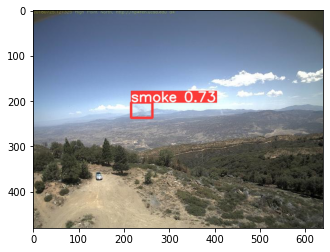

In [ ]:
# Change directory to where the results are saved
detections_dir = "/content/yolov5/yolov5/runs/detect/yolo_smoke_detection43"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

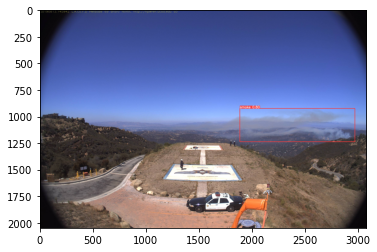

In [ ]:
# Change directory to where the results are saved
detections_dir = "/content/yolov5/yolov5/runs/detect/1db-sgd-100epoch"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

for image in detection_images:
  detection_image = Image.open(image)
  plt.imshow(np.array(detection_image))